In [1]:
import os
from dotenv import load_dotenv

# Load HF token from .env
load_dotenv()
hf_token = os.getenv('HUGGINGFACE_TOKEN')

# Login to HuggingFace
from huggingface_hub import login
login(token=hf_token)

In [1]:
import time
import psutil
import torch
import numpy as np
import pandas as pd
import subprocess
import logging
from dataclasses import dataclass
from typing import Dict, Optional, List, Tuple

from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer,
    DynamicCache, 
    OffloadedCache
)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class ModelConfig:
    model_name: str = "meta-llama/Llama-3.2-1B"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    cache_strategy: str = "dynamic"  # "dynamic" or "offloaded"
    use_cpu_decode: bool = False
    torch_dtype: torch.dtype = torch.float16

class HybridLlamaInference:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.setup()
    
    def setup(self):
        logger.info(f"Loading model '{self.config.model_name}' with cache strategy '{self.config.cache_strategy}'")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
        
        # Device map logic
        device_map = None
        if not self.config.use_cpu_decode:
            device_map = "auto"

        # Load model
        self.model = AutoModelForCausalLM.from_pretrained(
            self.config.model_name,
            torch_dtype=self.config.torch_dtype,
            device_map=device_map,
            low_cpu_mem_usage=True
        )

        # Convert model to float32 on CPU if use_cpu_decode is True to avoid fp16 CPU issues
        if self.config.use_cpu_decode:
            self.model.to('cpu', torch.float32)
        else:
            # If GPU, you can keep fp16
            self.model.to(self.config.device)

        self.tokenizer = AutoTokenizer.from_pretrained(self.config.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Initialize cache
        self.cache = DynamicCache() if self.config.cache_strategy == "dynamic" else OffloadedCache()
    
    def _get_gpu_metrics(self) -> Dict[str, float]:
        """Get GPU memory and utilization metrics (if GPU is available)."""
        metrics = {}
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / (1024**2)
            reserved = torch.cuda.memory_reserved() / (1024**2)
            fragmentation = reserved - allocated
            gpu_util = self._get_gpu_utilization()
            metrics = {
                'gpu_allocated_mb': allocated,
                'gpu_reserved_mb': reserved,
                'gpu_fragmentation_mb': fragmentation,
                'gpu_utilization_percent': gpu_util * 100.0
            }
        else:
            metrics = {
                'gpu_allocated_mb': 0.0,
                'gpu_reserved_mb': 0.0,
                'gpu_fragmentation_mb': 0.0,
                'gpu_utilization_percent': 0.0
            }
        return metrics

    def _get_cpu_metrics(self) -> Dict[str, float]:
        """Get CPU memory and utilization metrics."""
        process = psutil.Process()
        cpu_mem = process.memory_info().rss / (1024**2)
        cpu_util = psutil.cpu_percent(interval=None)
        return {
            'cpu_memory_mb': cpu_mem,
            'cpu_utilization_percent': cpu_util
        }

    def _get_gpu_utilization(self) -> float:
        """Get GPU utilization using nvidia-smi (0.0 if not available)."""
        if torch.cuda.is_available():
            try:
                result = subprocess.check_output(
                    ['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'],
                    encoding='utf-8'
                ).strip()
                util = float(result)
                return util / 100.0
            except Exception:
                return 0.0
        return 0.0

    def run_inference(
        self,
        input_text: str,
        max_new_tokens: int = 100,
        temperature: float = 1.0,
    ) -> Dict:
        # Prepare inputs on correct device
        if self.config.use_cpu_decode:
            device = 'cpu'
        else:
            device = self.config.device
        inputs = self.tokenizer(input_text, return_tensors="pt", truncation=True).to(device)

        # Metrics
        prefill_start = time.perf_counter()
        with torch.inference_mode():
            outputs = self.model(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                past_key_values=self.cache,
                use_cache=True
            )
        prefill_end = time.perf_counter()
        prefill_latency = prefill_end - prefill_start

        # Gather prefill metrics
        prefill_metrics = {}
        prefill_metrics.update(self._get_gpu_metrics())
        prefill_metrics.update(self._get_cpu_metrics())
        prefill_metrics['prefill_latency_sec'] = prefill_latency

        # Decode phase
        token_latencies = []
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        # Start decode
        decode_start = time.perf_counter()
        actual_tokens_generated = 0

        for _ in range(max_new_tokens):
            token_start = time.perf_counter()
            next_token_logits = outputs.logits[:, -1, :] / temperature
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            input_ids = torch.cat([input_ids, next_token], dim=-1)
            attention_mask = torch.cat([attention_mask, attention_mask.new_ones((1, 1), device=device)], dim=-1)

            with torch.inference_mode():
                outputs = self.model(
                    input_ids=next_token,
                    attention_mask=attention_mask,
                    past_key_values=self.cache,
                    use_cache=True
                )

            token_end = time.perf_counter()
            token_latency = token_end - token_start
            token_latencies.append(token_latency)
            actual_tokens_generated += 1

            if next_token.item() == self.tokenizer.eos_token_id:
                break

        decode_end = time.perf_counter()
        decode_latency = decode_end - decode_start
        if len(token_latencies) > 0:
            mean_latency = np.mean(token_latencies)
            p90_latency = np.percentile(token_latencies, 90)
            p99_latency = np.percentile(token_latencies, 99)
        else:
            mean_latency, p90_latency, p99_latency = 0.0, 0.0, 0.0

        # Gather decode metrics
        decode_metrics = {}
        decode_metrics.update(self._get_gpu_metrics())
        decode_metrics.update(self._get_cpu_metrics())
        decode_metrics['decode_latency_sec'] = decode_latency
        decode_metrics['mean_token_latency_sec'] = mean_latency
        decode_metrics['p90_token_latency_sec'] = p90_latency
        decode_metrics['p99_token_latency_sec'] = p99_latency
        tps = actual_tokens_generated / decode_latency if decode_latency > 0 else 0.0
        decode_metrics['tokens_per_second'] = tps

        generated_text = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)

        # Combine metrics
        metrics = {
            'prefill_latency_sec': prefill_metrics['prefill_latency_sec'],
            'decode_latency_sec': decode_metrics['decode_latency_sec'],
            'total_latency_sec': prefill_metrics['prefill_latency_sec'] + decode_metrics['decode_latency_sec'],
            'actual_output_length': actual_tokens_generated,
            'mean_token_latency_sec': decode_metrics['mean_token_latency_sec'],
            'p90_token_latency_sec': decode_metrics['p90_token_latency_sec'],
            'p99_token_latency_sec': decode_metrics['p99_token_latency_sec'],
            'tokens_per_second': decode_metrics['tokens_per_second'],
            
            # Memory and utilization stats at the end of decode (you can also store prefill stats separately)
            'final_gpu_allocated_mb': decode_metrics['gpu_allocated_mb'],
            'final_gpu_reserved_mb': decode_metrics['gpu_reserved_mb'],
            'final_gpu_fragmentation_mb': decode_metrics['gpu_fragmentation_mb'],
            'final_gpu_utilization_percent': decode_metrics['gpu_utilization_percent'],
            'final_cpu_memory_mb': decode_metrics['cpu_memory_mb'],
            'final_cpu_utilization_percent': decode_metrics['cpu_utilization_percent'],

            # Memory and utilization at prefill time (for comparison)
            'prefill_gpu_allocated_mb': prefill_metrics['gpu_allocated_mb'],
            'prefill_gpu_reserved_mb': prefill_metrics['gpu_reserved_mb'],
            'prefill_gpu_fragmentation_mb': prefill_metrics['gpu_fragmentation_mb'],
            'prefill_gpu_utilization_percent': prefill_metrics['gpu_utilization_percent'],
            'prefill_cpu_memory_mb': prefill_metrics['cpu_memory_mb'],
            'prefill_cpu_utilization_percent': prefill_metrics['cpu_utilization_percent'],
        }

        return {
            "text": generated_text,
            "metrics": metrics
        }

    def cleanup(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        if hasattr(self, 'model'):
            self.model.cpu()
            del self.model
        if hasattr(self, 'cache'):
            del self.cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.synchronize()
        import gc
        gc.collect()

class EnhancedDocumentLoader:
    def __init__(self, base_text: str = "This is a test document. It contains multiple sentences with varying content. "):
        self.base_text = base_text

    def load_chunk(self, chunk_size: int = 1000) -> str:
        sentences = self.base_text.split('. ')
        result = []
        current_length = 0
        while current_length < chunk_size:
            for sentence in sentences:
                result.append(sentence + ". ")
                current_length += len(sentence) + 2
                if current_length >= chunk_size:
                    break
        return "".join(result)

def run_comprehensive_test(
    config: ModelConfig,
    context_lengths: List[int] = [1024, 2048, 4096, 8192],
    output_lengths: List[int] = [20, 50, 100, 200],
    warmup: bool = True
) -> List[Dict]:
    results = []
    if warmup:
        logger.info("Performing warmup run...")
        try:
            llm = HybridLlamaInference(config)
            warmup_text = EnhancedDocumentLoader().load_chunk(chunk_size=1024)
            llm.run_inference(warmup_text, max_new_tokens=20)
            llm.cleanup()
        except Exception as e:
            logger.warning(f"Warmup run failed: {e}")

    for context_len in context_lengths:
        for output_len in output_lengths:
            try:
                llm = HybridLlamaInference(config)
                doc_loader = EnhancedDocumentLoader()
                input_text = doc_loader.load_chunk(chunk_size=context_len)

                start_time = time.perf_counter()
                result = llm.run_inference(input_text, max_new_tokens=output_len)
                end_time = time.perf_counter()

                # Add total run latency (including prefill + decode from metrics)
                total_latency = result["metrics"]['total_latency_sec']
                # You can add more derived metrics here if needed

                row = {
                    'strategy': config.cache_strategy,
                    'use_cpu_decode': config.use_cpu_decode,
                    'context_length': context_len,
                    'target_output_length': output_len,
                    'actual_output_length': result["metrics"]['actual_output_length'],
                    'prefill_latency_sec': result["metrics"]['prefill_latency_sec'],
                    'decode_latency_sec': result["metrics"]['decode_latency_sec'],
                    'total_latency_sec': total_latency,
                    'mean_token_latency_sec': result["metrics"]['mean_token_latency_sec'],
                    'p90_token_latency_sec': result["metrics"]['p90_token_latency_sec'],
                    'p99_token_latency_sec': result["metrics"]['p99_token_latency_sec'],
                    'tokens_per_second': result["metrics"]['tokens_per_second'],
                    'prefill_gpu_allocated_mb': result["metrics"]['prefill_gpu_allocated_mb'],
                    'prefill_gpu_reserved_mb': result["metrics"]['prefill_gpu_reserved_mb'],
                    'prefill_gpu_fragmentation_mb': result["metrics"]['prefill_gpu_fragmentation_mb'],
                    'prefill_gpu_utilization_percent': result["metrics"]['prefill_gpu_utilization_percent'],
                    'prefill_cpu_memory_mb': result["metrics"]['prefill_cpu_memory_mb'],
                    'prefill_cpu_utilization_percent': result["metrics"]['prefill_cpu_utilization_percent'],
                    'final_gpu_allocated_mb': result["metrics"]['final_gpu_allocated_mb'],
                    'final_gpu_reserved_mb': result["metrics"]['final_gpu_reserved_mb'],
                    'final_gpu_fragmentation_mb': result["metrics"]['final_gpu_fragmentation_mb'],
                    'final_gpu_utilization_percent': result["metrics"]['final_gpu_utilization_percent'],
                    'final_cpu_memory_mb': result["metrics"]['final_cpu_memory_mb'],
                    'final_cpu_utilization_percent': result["metrics"]['final_cpu_utilization_percent']
                }

                results.append(row)
            except Exception as e:
                logger.error(f"Error testing context_len={context_len}, output_len={output_len}: {str(e)}")
            finally:
                if 'llm' in locals():
                    llm.cleanup()

    return results

In [2]:
# Example usage
configs = [
    ModelConfig(cache_strategy="dynamic", use_cpu_decode=False),
    ModelConfig(cache_strategy="dynamic", use_cpu_decode=True),
    ModelConfig(cache_strategy="offloaded", use_cpu_decode=False),
    ModelConfig(cache_strategy="offloaded", use_cpu_decode=True)
]

context_lengths = [65536]
output_lengths = [100]
all_results = {}

for config in configs:
    name = f"{config.cache_strategy}_cpu{config.use_cpu_decode}"
    all_results[name] = run_comprehensive_test(config, context_lengths=context_lengths, output_lengths=output_lengths, warmup=True)
    print(f"Finished testing {name}")

# Convert to DataFrame
df = pd.DataFrame([r for strat_results in all_results.values() for r in strat_results])
df.to_csv("benchmark_results_longcontext.csv", index=False)
print("Enhanced benchmark results saved to benchmark_results_longcontext.csv")

df.head()

INFO:__main__:Performing warmup run...
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
/home/jbi4001/miniforge3/envs/llm_bench/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jbi4001/miniforge3/envs/llm_bench/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces

Finished testing dynamic_cpuFalse


INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Performing warmup run...
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Finished testing dynamic_cpuTrue


INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
ERROR:__main__:Error testing context_len=65536, output_len=100: CUDA out of memory. Tried to allocate 18.02 GiB (GPU 0; 22.17 GiB total capacity; 11.86 GiB already allocated; 9.20 GiB free; 12.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
INFO:__main__:Performing warmup run...
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'


Finished testing offloaded_cpuFalse


INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'


Finished testing offloaded_cpuTrue
Enhanced benchmark results saved to benchmark_results_longcontext.csv


,strategy,use_cpu_decode,context_length,target_output_length,actual_output_length,prefill_latency_sec,decode_latency_sec,total_latency_sec,mean_token_latency_sec,p90_token_latency_sec,...,prefill_gpu_fragmentation_mb,prefill_gpu_utilization_percent,prefill_cpu_memory_mb,prefill_cpu_utilization_percent,final_gpu_allocated_mb,final_gpu_reserved_mb,final_gpu_fragmentation_mb,final_gpu_utilization_percent,final_cpu_memory_mb,final_cpu_utilization_percent
0,dynamic,True,65536,100,100,290.794920,54.097619,344.892540,0.540919,0.542276,...,11.875,0.0,14847.531250,5.6,8.125,20.0,11.875,0.0,8649.078125,7.1
1,offloaded,True,65536,100,100,286.761143,52.031093,338.792237,0.520256,0.530170,...,11.875,0.0,15037.746094,5.7,8.125,20.0,11.875,0.0,8600.332031,7.1


In [6]:
critical_contexts = df[df['context_length'].isin([16384, 32768])]
summary = critical_contexts.groupby(['use_cpu_decode', 'strategy'])[
    ['final_gpu_allocated_mb', 'final_cpu_memory_mb', 'tokens_per_second']
].mean()

print(summary)

                          final_gpu_allocated_mb  final_cpu_memory_mb  \
use_cpu_decode strategy                                                 
True           dynamic                     8.125          8649.078125   
               offloaded                   8.125          8600.332031   

                          tokens_per_second  
use_cpu_decode strategy                      
True           dynamic             1.848510  
               offloaded           1.921928  


strategy use_cpu_decode context_length tokens_per_second             \
                                                         mean        std   
0     dynamic          False           1024         77.009088   2.251273   
1     dynamic          False           2048         77.113550   1.010134   
2     dynamic          False           4096         75.137942   2.867230   
3     dynamic          False           8192         68.709848   9.559905   
4     dynamic          False          16384         55.602101  17.618214   
5     dynamic          False          32768         34.398225  19.429161   
6     dynamic           True           1024          8.032837   0.055704   
7     dynamic           True           2048          7.931848   0.106189   
8     dynamic           True           4096          7.848214   0.144531   
9     dynamic           True           8192          6.725819   0.236943   
10    dynamic           True          16384          5.373591   0.137908   
11    dynamic           True          32768          2.927577   0.147232   
12  offloaded          False           1024         69.728527   0.650986   
13  offloaded          False           2048         68.806837   1.878472   
14  offloaded          False           4096         66.956520   3.038450   
15  offloaded          False           8192         60.121872   7.336638   
16  offloaded          False          16384         38.455000   8.411854   
17  offloaded          False          32768         19.659481   7.498275   
18  offloaded           True           1024          7.870711   0.057652   
19  offloaded           True           2048          7.980972   0.138905   
20  offloaded           True           4096          7.570714   0.180750   
21  offloaded           True           8192          6.786577   0.256947   
22  offloaded           True          16384          5.127288   0.175503   
23  offloaded           True          32768          2.889652   0.096443   

                         total_latency_sec mean_token_latency_sec  \
          max        min              mean                   mean   
0   78.733474  73.200803          2.250601               0.011913   
1   78.240096  75.987727          2.260166               0.011890   
2   77.350683  70.242487          2.287382               0.012055   
3   77.332105  53.503889          2.347530               0.012644   
4   73.953208  29.465571          2.645403               0.016122   
5   59.612717  10.534946          3.999377               0.031240   
6    8.117107   7.968799         22.651771               0.124449   
7    8.065560   7.832208         23.715688               0.126045   
8    7.982012   7.623366         26.320722               0.127404   
9    6.991970   6.447899         34.968433               0.148778   
10   5.531163   5.247618         53.096725               0.186141   
11   3.187586   2.825176        130.751710               0.342161   
12  70.391077  68.687231          2.505136               0.013259   
13  70.262019  65.679827          2.505030               0.013455   
14  68.870361  61.769413          2.557358               0.013894   
15  65.744662  47.961294          2.736590               0.015733   
16  46.080552  25.434188          4.026519               0.025781   
17  27.947678   9.174548          7.274275               0.057304   
18   7.916761   7.771341         23.329346               0.127015   
19   8.071291   7.734911         23.794982               0.125283   
20   7.876400   7.405594         26.876316               0.132098   
21   7.001780   6.430246         34.387373               0.147472   
22   5.255755   4.829268         54.491790               0.195174   
23   3.062072   2.842571        132.997070               0.346303   

   p90_token_latency_sec p99_token_latency_sec final_cpu_memory_mb  \
                    mean                  mean                mean   
0               0.011902              0.014344         3598.027344   
1               0.01190

,strategy,use_cpu_decode,tokens_per_second,total_latency_sec,mean_token_latency_sec,p90_token_latency_sec,final_cpu_memory_mb,final_gpu_allocated_mb
0,dynamic,False,68.709848,2.347530,0.012644,0.011712,3598.251563,2421.236133
1,dynamic,True,6.725819,34.968433,0.148778,0.150510,8020.427344,8.125000
2,offloaded,False,60.121872,2.736590,0.015733,0.013794,3716.678125,2373.741602
3,offloaded,True,6.786577,34.387373,0.147472,0.149152,8319.850000,8.125000


,strategy,use_cpu_decode,context_length
0,dynamic,False,32768
1,dynamic,True,32768
2,offloaded,False,32768
3,offloaded,True,32768


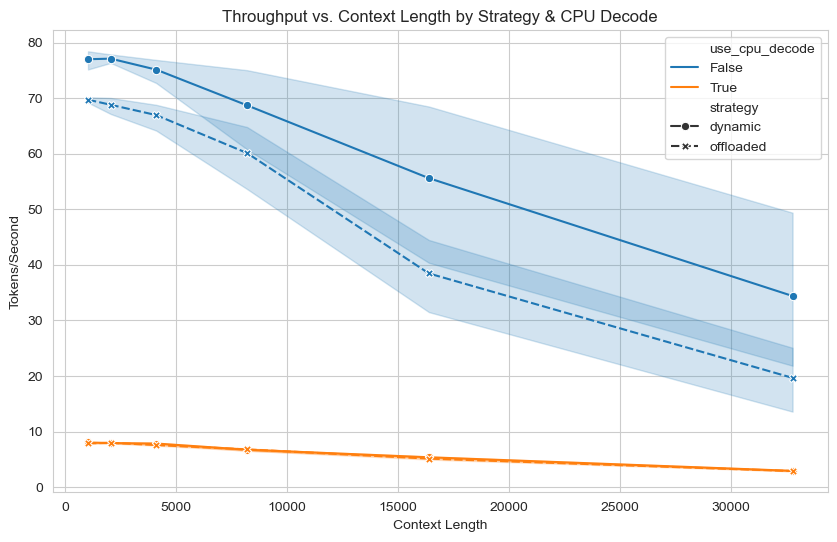

strategy   context_length
dynamic    1024              0.109871
           2048              0.103220
           4096              0.113635
           8192              0.129936
           16384             0.187716
           32768             0.271479
offloaded  1024              0.113265
           2048              0.122208
           4096              0.127513
           8192              0.137544
           16384             0.205678
           32768             0.309832
Name: cpu_gpu_tps_ratio, dtype: float64

In [8]:
import pandas as pd

# 1. Group by strategy and context length to get average performance metrics
grouped = df.groupby(['strategy', 'use_cpu_decode', 'context_length']).agg({
    'tokens_per_second': ['mean', 'std', 'max', 'min'],
    'total_latency_sec': ['mean'],
    'mean_token_latency_sec': ['mean'],
    'p90_token_latency_sec': ['mean'],
    'p99_token_latency_sec': ['mean'],
    'final_cpu_memory_mb': ['mean'],
    'final_gpu_allocated_mb': ['mean'],
    'final_gpu_utilization_percent': ['mean']
}).reset_index()

display(grouped)

# 2. Compare CPU vs GPU decode for each strategy at a given context length
# Let's pick a context length (e.g., 8192)
cpu_vs_gpu_8192 = df[df['context_length'] == 8192].groupby(['strategy', 'use_cpu_decode']).agg({
    'tokens_per_second': 'mean',
    'total_latency_sec': 'mean',
    'mean_token_latency_sec': 'mean',
    'p90_token_latency_sec': 'mean',
    'final_cpu_memory_mb': 'mean',
    'final_gpu_allocated_mb': 'mean'
}).reset_index()

display(cpu_vs_gpu_8192)

# 3. Find the maximum context length each strategy can handle without OOM (if that was tested)
# Assuming OOM runs were skipped or had exceptions, you might have a column or a condition.
# If not, just see where performance drastically changes:
max_context_per_strategy = df.groupby(['strategy', 'use_cpu_decode'])['context_length'].max().reset_index()
display(max_context_per_strategy)

# 4. Identify performance cliffs
# For example, plot tokens_per_second vs. context_length for CPU vs GPU decode:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(
    data=df,
    x='context_length', 
    y='tokens_per_second', 
    hue='use_cpu_decode', 
    style='strategy',
    markers=True,
    ax=ax
)
ax.set_title("Throughput vs. Context Length by Strategy & CPU Decode")
ax.set_ylabel("Tokens/Second")
ax.set_xlabel("Context Length")
plt.show()

# 5. Summarize Key Findings in Textual Form (example steps in a Markdown cell):
# - The CPU decode mode enables running at larger context lengths at the expense of roughly X% reduction in tokens/sec.
# - At 8K context length, offloaded CPU decode provides Y% more tokens than GPU-only decode under memory constraints.
# - P90 token latency significantly increases beyond 16K context lengths, indicating diminishing returns.

# 6. Compute ratios or differences to quantify the tradeoffs:
# For instance, ratio of CPU decode tokens/sec to GPU decode tokens/sec for each strategy and context length:
df['cpu_gpu_tps_ratio'] = df.groupby(['strategy', 'context_length'])['tokens_per_second'].transform(
    lambda x: x[df['use_cpu_decode']==True].values[0] / x[df['use_cpu_decode']==False].values[0] if (
        sum(df['use_cpu_decode']==True) > 0 and sum(df['use_cpu_decode']==False) > 0
    ) else None
)

# Check these ratios to see how CPU decoding affects throughput at each context length
ratio_summary = df.dropna(subset=['cpu_gpu_tps_ratio']).groupby(['strategy', 'context_length'])['cpu_gpu_tps_ratio'].mean()
display(ratio_summary)

# Now you have a measure: if cpu_gpu_tps_ratio < 1, CPU decode is slower; how much slower?
# This directly quantifies the tradeoff in performance for extended context length support.


In [9]:
grouped_output = df.groupby(['strategy', 'use_cpu_decode', 'context_length', 'target_output_length']).agg({
    'tokens_per_second': ['mean', 'std'],
    'mean_token_latency_sec': 'mean',
    'p90_token_latency_sec': 'mean',
    'p99_token_latency_sec': 'mean'
}).reset_index()

display(grouped_output)


strategy use_cpu_decode context_length target_output_length  \
                                                                    
0      dynamic          False           1024                   20   
1      dynamic          False           1024                   50   
2      dynamic          False           1024                  100   
3      dynamic          False           1024                  200   
4      dynamic          False           1024                  500   
..         ...            ...            ...                  ...   
115  offloaded           True          32768                   20   
116  offloaded           True          32768                   50   
117  offloaded           True          32768                  100   
118  offloaded           True          32768                  200   
119  offloaded           True          32768                  500   

    tokens_per_second     mean_token_latency_sec p90_token_latency_sec  \
                 mean std                   mean                  mean   
0           73.200803 NaN               0.012582              0.012390   
1           78.733474 NaN               0.011615              0.011669   
2           76.757720 NaN               0.011944              0.011884   
3           78.233561 NaN               0.011699              0.011733   
4           78.119880 NaN               0.011722              0.011835   
..                ...  ..                    ...                   ...   
115          2.842571 NaN               0.351737              0.352571   
116          2.844033 NaN               0.351557              0.355700   
117          2.850495 NaN               0.350762              0.352933   
118          3.062072 NaN               0.326522              0.330732   
119          2.849087 NaN               0.350935              0.359725   

    p99_token_latency_sec  
                     mean  
0                0.017679  
1                0.014885  
2                0.014404  
3                0.012317  
4                0.012436  
..                    ...  
115              0.397282  
116              0.377100  
117              0.357013  
118              0.333705  
119              0.379847  

[120 rows x 9 columns]

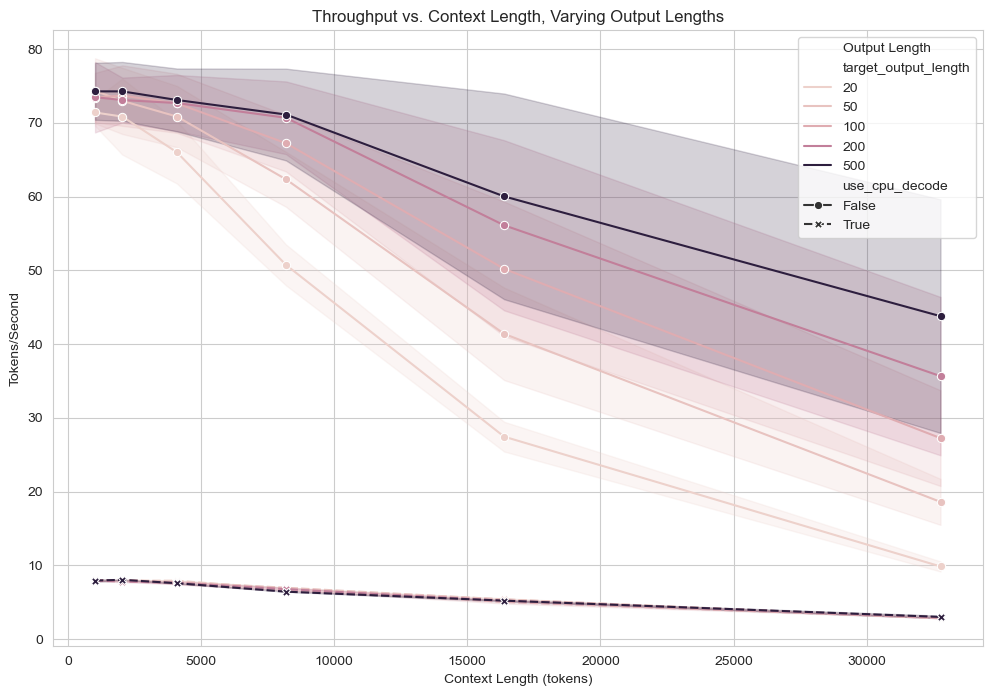

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(12,8))

# Plot tokens_per_second by context_length, but also distinguish by output length
sns.lineplot(
    data=df,
    x='context_length',
    y='tokens_per_second',
    hue='target_output_length',   # Different line for each output length
    style='use_cpu_decode',       # Different line style for CPU vs GPU decode
    markers=True
)

plt.title("Throughput vs. Context Length, Varying Output Lengths")
plt.xlabel("Context Length (tokens)")
plt.ylabel("Tokens/Second")
plt.legend(title="Output Length")
plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


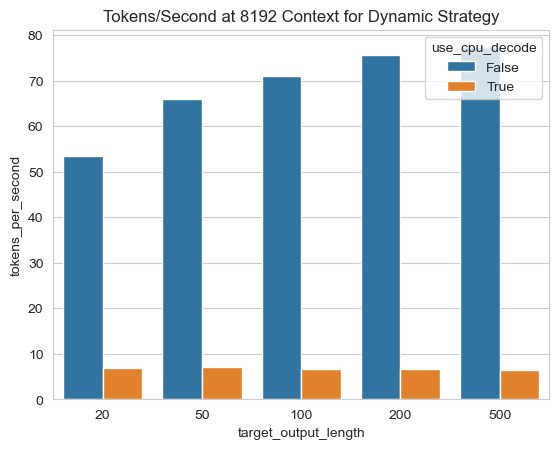

In [11]:
subset = df[(df['strategy'] == 'dynamic') & (df['context_length'] == 8192)]
sns.barplot(
    data=subset,
    x='target_output_length',
    y='tokens_per_second',
    hue='use_cpu_decode'
)
plt.title("Tokens/Second at 8192 Context for Dynamic Strategy")
plt.show()


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

final_df = pd.read_csv("benchmark_results_enhanced.csv")

# Assuming you already have a DataFrame 'grouped_output'
df = final_df.copy()

# Check basic info
print(df.describe())
print(df.dtypes)


       context_length  target_output_length  actual_output_length  \
count      120.000000            120.000000            120.000000   
mean     10752.000000            174.000000            174.000000   
std      11134.571917            174.810341            174.810341   
min       1024.000000             20.000000             20.000000   
25%       2048.000000             50.000000             50.000000   
50%       6144.000000            100.000000            100.000000   
75%      16384.000000            200.000000            200.000000   
max      32768.000000            500.000000            500.000000   

       prefill_latency_sec  decode_latency_sec  total_latency_sec  \
count           120.000000          120.000000         120.000000   
mean              9.062707           16.969680          26.032387   
std              20.229821           29.087942          42.935862   
min               0.016078            0.263200           0.280859   
25%               0.017735       

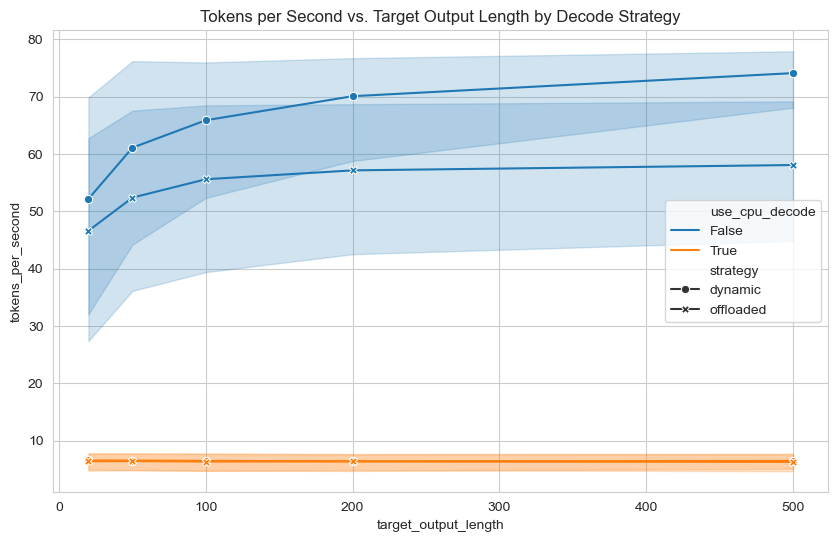

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="target_output_length",
    y="tokens_per_second",
    hue="use_cpu_decode",
    style="strategy",  # "strategy" might represent kv-cache strategy (gpu mem vs. cpu mem)
    markers=True,
    dashes=False
)
plt.title("Tokens per Second vs. Target Output Length by Decode Strategy")
plt.show()


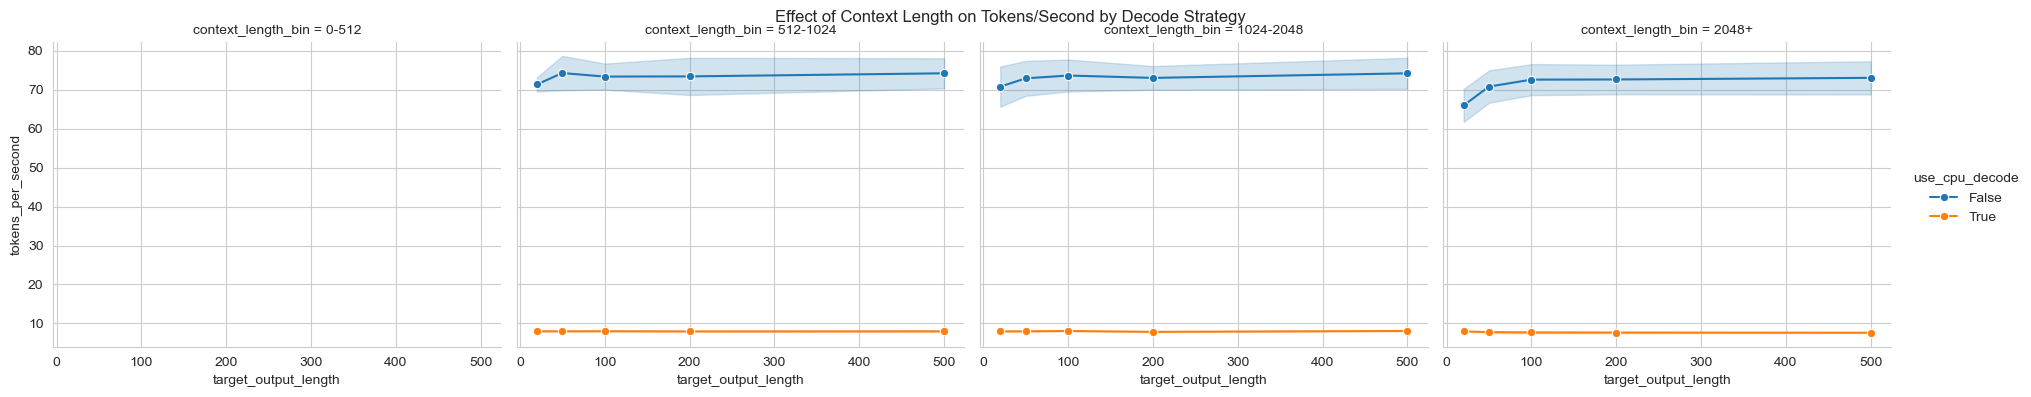

In [19]:
# Create bins for context_length (for example, low, medium, high)
df['context_length_bin'] = pd.cut(df['context_length'], bins=[0, 512, 1024, 2048, 4096], labels=["0-512","512-1024","1024-2048","2048+"])

g = sns.FacetGrid(df, col="context_length_bin", hue="use_cpu_decode", height=4, aspect=1.2)
g.map(sns.lineplot, "target_output_length", "tokens_per_second", marker="o")
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Effect of Context Length on Tokens/Second by Decode Strategy")
plt.show()


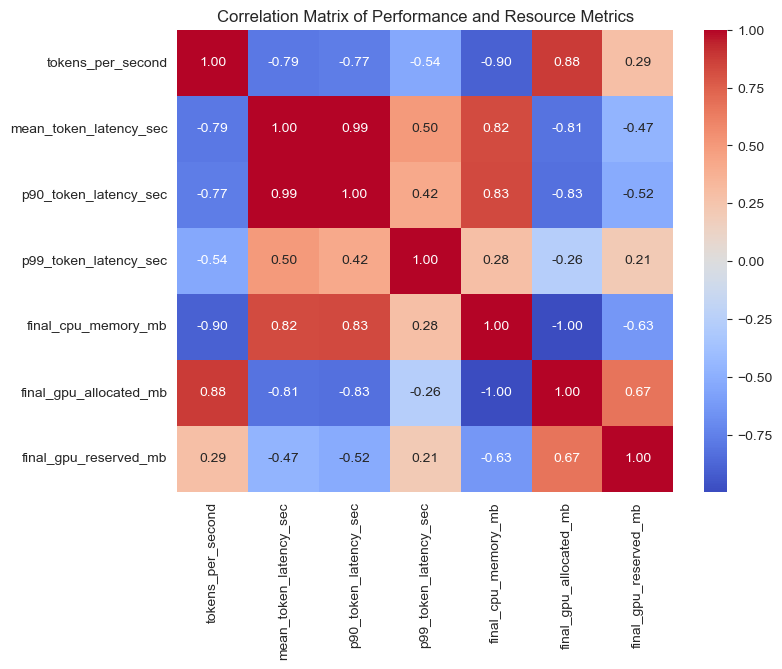

In [20]:
# Select relevant numeric columns for correlation
cols_of_interest = [
    "tokens_per_second", 
    "mean_token_latency_sec", 
    "p90_token_latency_sec", 
    "p99_token_latency_sec", 
    "final_cpu_memory_mb", 
    "final_gpu_allocated_mb", 
    "final_gpu_reserved_mb"
]

corr = df[cols_of_interest].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Performance and Resource Metrics")
plt.show()


In [21]:
import statsmodels.formula.api as smf

# Convert boolean fields to int (if needed)
df['use_cpu_decode_int'] = df['use_cpu_decode'].astype(int)

model = smf.ols("tokens_per_second ~ use_cpu_decode_int + context_length + target_output_length + final_gpu_allocated_mb + final_cpu_memory_mb", data=df)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:      tokens_per_second   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     191.7
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           9.29e-54
Time:                        15:31:11   Log-Likelihood:                -443.60
No. Observations:                 120   AIC:                             899.2
Df Residuals:                     114   BIC:                             915.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                238